In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# Add personal library
import sys
sys.path.append('../..')
import py_ml.lib as lib

# Cross-Validation and Bias-Variance decomposition
## Cross-Validation
Implementing 4-fold cross-validation below:

In [2]:
from helpers import load_data

# load dataset
x, y = load_data()
print(np.shape(y), np.shape(x))

(50,) (50,)


In [3]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

In [4]:
# from costs import compute_mse
# from ridge_regression import ridge_regression
# from build_polynomial import build_poly

def cross_validation(y, x, k_indices, k, lambda_, degree):
    """return the loss of ridge regression."""
    
    # Get indices for train and test sets
    _ind_train = np.delete(k_indices, k, axis=0).flatten()
    _ind_test = k_indices[k]
    
    # Build polynomial matrix
    _phi_train = lib.build_poly(x[_ind_train], degree)
    _phi_test = lib.build_poly(x[_ind_test], degree)
    
    # Compute ridge regression and loss for both train and test set
    loss_tr, weights = lib.ridge_regression(y[_ind_train], _phi_train, lambda_)
    loss_te = lib.mse(y[_ind_test], _phi_test.dot(weights))
    
    return loss_tr, loss_te

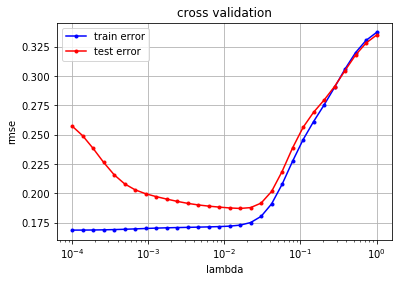

In [5]:
from plots import cross_validation_visualization

def cross_validation_demo():
    seed = 0
    k_fold = 4
    degree = 7
    lambdas = np.logspace(-4, 0, 30)
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    
    for i, _lambda in enumerate(lambdas):
        _rmse_tr = np.empty(k_fold)
        _rmse_te = np.empty(k_fold)
        # Performs k-fold validation
        for k in range(k_fold):
            _rmse_tr[k], _rmse_te[k] = cross_validation(y, x, k_indices, k, _lambda, degree)
            _rmse_tr[k], _rmse_te[k] = np.sqrt(_rmse_tr[k]), np.sqrt(_rmse_te[k])
        # Take mean value
        rmse_tr.append(np.mean(_rmse_tr))
        rmse_te.append(np.mean(_rmse_te))
        
    cross_validation_visualization(lambdas, rmse_tr, rmse_te)

cross_validation_demo()

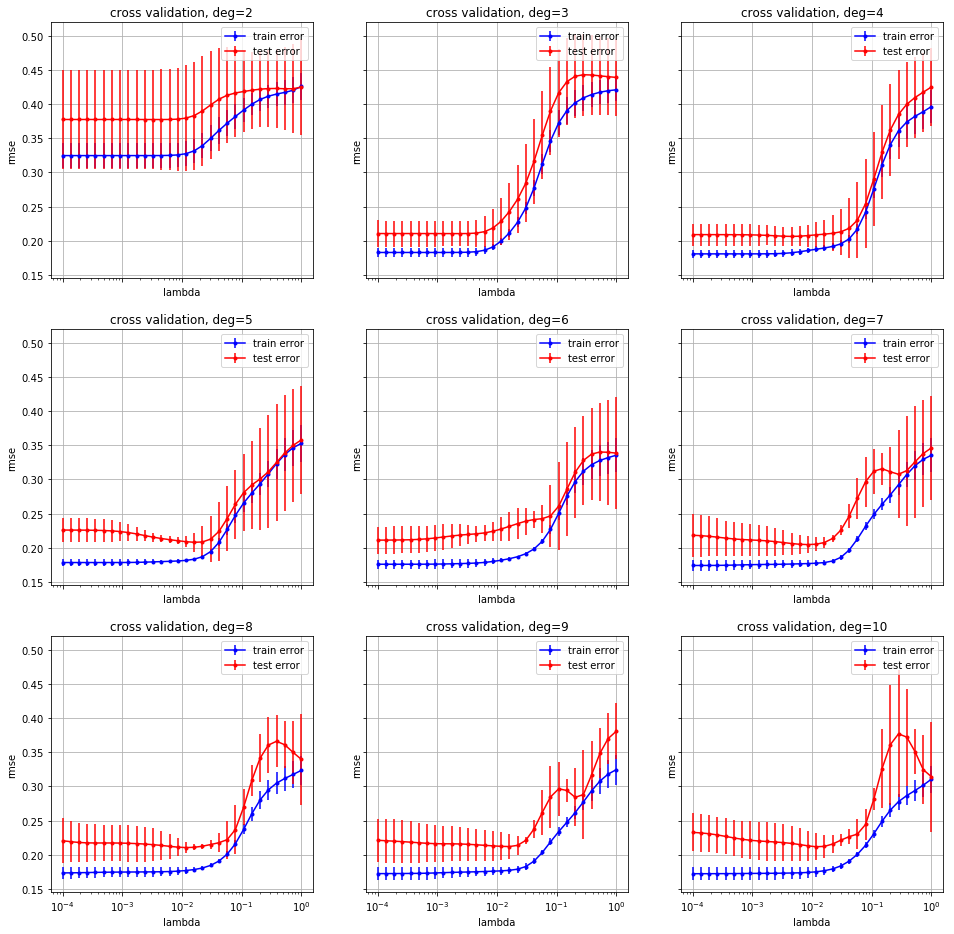

In [6]:
from plots import cross_validation_visualization_deg

def cross_validation_demo_deg(degree = 7, ax=None):
    seed = 1
    k_fold = 4
    lambdas = np.logspace(-4, 0, 30)
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    # define lists to tore the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    var_tr = []
    var_te = []
    
    for i, _lambda in enumerate(lambdas):
        _rmse_tr = np.empty(k_fold)
        _rmse_te = np.empty(k_fold)
        # Performs k-fold validation
        for k in range(k_fold):
            _rmse_tr[k], _rmse_te[k] = cross_validation(y, x, k_indices, k, _lambda, degree)
            _rmse_tr[k], _rmse_te[k] = np.sqrt(_rmse_tr[k]), np.sqrt(_rmse_te[k])
        # Take mean value
        rmse_tr.append(np.mean(_rmse_tr))
        rmse_te.append(np.mean(_rmse_te))
        var_tr.append(np.std(_rmse_tr))
        var_te.append(np.std(_rmse_te))
        
    cross_validation_visualization_deg(lambdas, rmse_tr, rmse_te, var_tr, var_te, ax, degree)


fig, axes = plt.subplots(3,3, sharex=True, sharey=True, figsize=(16,16))
for i, d in enumerate(range(2,11)):
    cross_validation_demo_deg(d, axes[i//3, np.mod(i, 3)])

## Bias-Variance Decomposition
Visualize bias-variance trade-off by implementing the function `bias_variance_demo()` below:

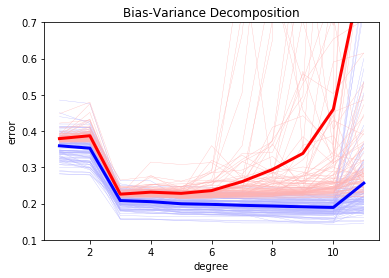

In [7]:
from least_squares import least_squares
from split_data import split_data
from plots import bias_variance_decomposition_visualization, bias_variance_decomposition_visualization_box

def best_lambda(y, x, degree=7, k_fold = 4, seed = 1):
    lambdas = np.logspace(-4, 0, 30)
    
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    # define lists to tore the loss of training data and test data
    rmse_tr = np.empty(len(lambdas))
    rmse_te = np.empty(len(lambdas))
    
    for i, _lambda in enumerate(lambdas):
        _rmse_tr = np.empty(k_fold)
        _rmse_te = np.empty(k_fold)
        # Performs k-fold validation
        for k in range(k_fold):
            _rmse_tr[k], _rmse_te[k] = cross_validation(y, x, k_indices, k, _lambda, degree)
            _rmse_tr[k], _rmse_te[k] = np.sqrt(_rmse_tr[k]), np.sqrt(_rmse_te[k])
        # Take mean value
        rmse_tr[i] = np.mean(_rmse_tr)
        rmse_te[i] = np.mean(_rmse_te)

    # cross_validation_visualization(lambdas, rmse_tr, rmse_te)
    return lambdas[np.argmin(rmse_te)]
# best_lambda(y, x, degree=8)

def bias_variance_demo(method='ls', plot='regular'):
    """The entry."""
    # define parameters
    seeds = range(100)
    num_data = 10000
    ratio_train = 0.005
    degrees = range(1, 12)
    
    # define list to store the variable
    rmse_tr = np.empty((len(seeds), len(degrees)))
    rmse_te = np.empty((len(seeds), len(degrees)))
    
    for index_seed, seed in enumerate(seeds):
        np.random.seed(seed)
        x = np.linspace(0.1, 2 * np.pi, num_data)
        y = np.sin(x) + 0.3 * np.random.randn(num_data).T
        
        # split data with a specific seed
        x_train, x_test, y_train, y_test = lib.split_data(x, y, ratio_train, seed)
           
        for index_degree, degree in enumerate(degrees):
            # Build polynomial matrix
            _tx_train = lib.build_poly(x_train, degree)
            _tx_test = lib.build_poly(x_test, degree)
            
            # Compute ridge regression and loss for both train and test set
            if method == 'ls':
                loss_tr, weights = lib.least_squares(y_train, _tx_train)
            elif method == 'ridge':
                lam = best_lambda(y_train, x_train, degree=degree)
                loss_tr, weights = lib.ridge_regression(y_train, _tx_train, lam)
                
            loss_te = lib.mse(y_test, _tx_test.dot(weights))
            
            rmse_tr[index_seed, index_degree] = np.sqrt(loss_tr)
            rmse_te[index_seed, index_degree] = np.sqrt(loss_te)

    if plot == 'regular':
            bias_variance_decomposition_visualization(degrees, rmse_tr, rmse_te)
    elif plot == 'box':
            bias_variance_decomposition_visualization_box(degrees, rmse_tr, rmse_te)

bias_variance_demo(method='ls')

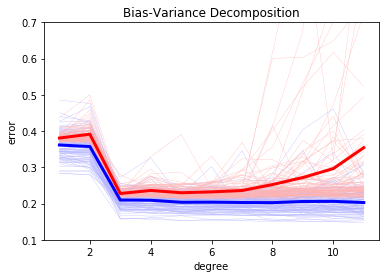

In [8]:
bias_variance_demo(method='ridge')

### Boxplot (Variance and bias)

We can see that ridge regression is way more stable. Even for larger values the variance is still low. Note that it takes also a lot more time to compute the model

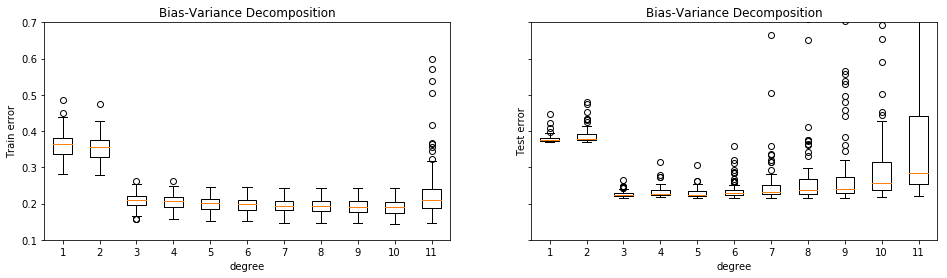

In [9]:
bias_variance_demo(method='ls', plot='box')

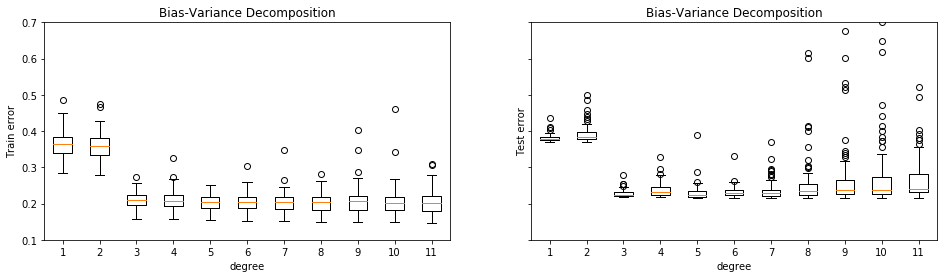

In [10]:
bias_variance_demo(method='ridge', plot='box')